# Notebook XX: The Freeboard Problem

In [1]:
# import packages

import xarray as xr
import matplotlib
import numpy as np
import os
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle

#magic for plots to show up below cells
%matplotlib inline

**Read in the converted obs_final.nc and obs_start.nc files.** 

"obs_final.nc" is the obs_seq.final file, which contains (1) a copy of the observation, (2) the ensemble mean and standard deviation estimation of the prior and posterior, and (3) each individual ensemble member's estimation of the observations 

"obs_start.nc" is the obs_seq.DATE file (the observation file used in the assimilation, created by me) converted to netcdf format.

The experiment being analyzed is "DA30_vicen_FB_mem_0024_noerr", which is the default volume update case that assimilates *freeboard* from ensemble member *24* with no added error.

In [2]:
# set paths
file1 = '/glade/work/mollyw/dart_manhattan/models/cice/work/fb_obs_final.nc'
file2 = '/glade/work/mollyw/dart_manhattan/models/cice/work/fb_obs_start.nc'

file3 = '/glade/work/mollyw/dart_manhattan/models/cice/work/hi_obs_final.nc'
file4 = '/glade/work/mollyw/dart_manhattan/models/cice/work/hi_obs_start.nc'

# open files
fb_input_obs = xr.open_dataset(file2)
fb_model_obs = xr.open_dataset(file1)

hi_input_obs = xr.open_dataset(file4)
hi_model_obs = xr.open_dataset(file3)

**Print one of the model files to explore.**

The dimensions describe *how many* observations there are (**ObsIndex**), *how many types* of observations there are (presumably in the cice module of DART, **ObsTypes**), *how many "copies"* of the observations there are (**copy**), the *spatial dimensions* (**locdim**), the *number of lines in the namelist* (**nlines**), and the *quality control record* (**qc_copy**).

**copy**
- A copy is (to my understanding) a record of the observation. It can be the original obs, a reduction of the obs, or the model estimation of the obs. In the case of the model obs_final file, there are copies to describe the original observation, the ensemble mean and error variance of the observation, and each ensemble member's prior and posterior estimation of the observation. In the input obs_start file, there are two copies of the observation: the observation itself and the observation error variance.

**qc_copy**
- Relatedly to the copy mechanism, a qc_copy is a record of quality control. There is a DART QC in both the obs_final and obs_start files which is the number assigned to the observation in the process of generating an obs_seq.DATE file from a set of real or synthetic observations. There is a second DART quality control value in the obs_final file that describes whether the observation was rejected or not during the assimilation (qc > 3).

In [3]:
# print one of these files
fb_model_obs

<xarray.Dataset>
Dimensions:           (ObsIndex: 482, ObsTypes: 16, copy: 66, locdim: 3, nlines: 324, qc_copy: 2)
Coordinates:
  * copy              (copy) int32 1 2 3 4 5 6 7 8 9 ... 59 60 61 62 63 64 65 66
  * qc_copy           (qc_copy) int32 1 2
  * ObsTypes          (ObsTypes) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * ObsIndex          (ObsIndex) int32 1 2 3 4 5 6 7 ... 477 478 479 480 481 482
Dimensions without coordinates: locdim, nlines
Data variables:
    ObsTypesMetaData  (ObsTypes) |S32 ...
    QCMetaData        (qc_copy) |S32 ...
    CopyMetaData      (copy) |S32 ...
    namelist          (nlines) |S256 ...
    time              (ObsIndex) datetime64[ns] ...
    obs_type          (ObsIndex) int32 ...
    obs_keys          (ObsIndex) int32 ...
    observations      (ObsIndex, copy) float64 ...
    qc                (ObsIndex, qc_copy) int32 ...
    location          (ObsIndex, locdim) float64 ...
    which_vert        (ObsIndex) int32 ...
Attributes:
    creation_date:             YYYY MM DD HH MM SS = 2021 09 30 14 23 39
    obs_seq_to_netcdf_source:  obs_seq_to_netcdf.f90
    obs_seq_file_001:          /glade/scratch/mollyw/DA30_vicen_FB_mem_0024_n...

### Is it the observations?

**Plot the histogram of the observations against the histogram of the prior estimate of the truth member.** 

This should describe the degree to which our method of deriving synthetic measurements does or does not match what the model does to estimate the state version of those measurements. They should be identical, given that we've theoretically used the same forward operator. 

<xarray.DataArray 'CopyMetaData' ()>
array(b'prior ensemble member     24    ', dtype='|S32')
Coordinates:
    copy     int32 52
Attributes:
    long_name:  quantity names


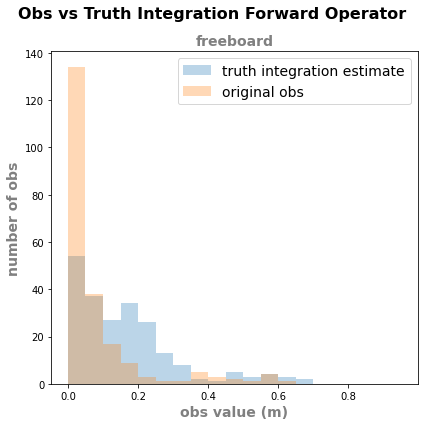

In [4]:
c = 52

# check that we're using the right prior
print(fb_model_obs.sel(copy=52).CopyMetaData)

# do calculations
data1 = fb_model_obs.where(fb_model_obs.qc <=3).observations.sel(copy=c)[:,1]
data2 = fb_model_obs.where(fb_model_obs.qc <=3).observations.sel(copy=1)[:,1]

binedges = [x/100 for x in range(0,100,5)] #,  0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

fig = plt.figure(figsize=(6,6))
plt.hist(data1, 
         bins=binedges, 
         alpha = 0.3,
         label = 'truth integration estimate'
        ) # np.arange(np.min(data1), np.max(data1) + binwidth, binwidth), 
plt.hist(data2,
         bins=binedges, 
         alpha = 0.3, 
         label = 'original obs'
        )
plt.suptitle('Obs vs Truth Integration Forward Operator', fontweight='bold',fontsize = 16)
plt.title('freeboard', fontweight='bold', fontsize = 14, color = 'grey')
plt.xlabel('obs value (m)', fontweight = 'bold',fontsize = 14, color = 'grey')
plt.ylabel('number of obs', fontweight = 'bold', fontsize = 14, color = 'grey')
plt.legend(fontsize = 14)

plt.tight_layout()

From this, we learn that the original observations (written by me) have far more values at lower freeboards (almost 2x), and far fewer values at higher freeboards than the model's estimate of the observations. In practice, this could theoretically cause the model estimates to be shifted lower overall. A test for this will be whether this same pattern exists in the thickness cases, which has a much simpler forward operator.

### Is there a mismatch in thickness estimates?

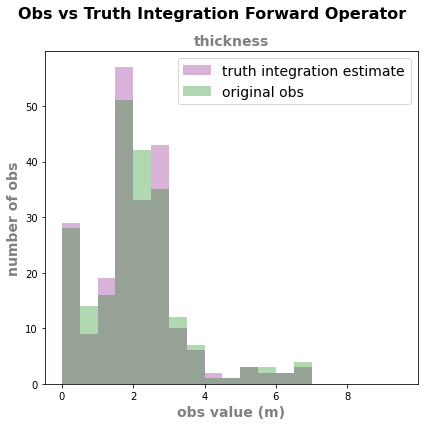

In [5]:
c = 52
data1 = hi_model_obs.where(fb_model_obs.qc <=3).observations.sel(copy=c)[:,1]
data2 = hi_model_obs.where(fb_model_obs.qc <=3).observations.sel(copy=1)[:,1]

binedges = [x/10 for x in range(0,100,5)]

fig = plt.figure(figsize=(6,6))
plt.hist(data1, 
         bins=binedges, 
         alpha = 0.3,
         color = 'purple',
         label = 'truth integration estimate'
        ) # np.arange(np.min(data1), np.max(data1) + binwidth, binwidth), 
plt.hist(data2,
         bins=binedges, 
         alpha = 0.3, 
         color = 'green',
         label = 'original obs'
        )
plt.suptitle('Obs vs Truth Integration Forward Operator', fontweight = 'bold',fontsize = 16)
plt.title('thickness', fontweight='bold', fontsize = 14, color = 'grey')
plt.xlabel('obs value (m)', fontweight = 'bold',fontsize = 14, color = 'grey')
plt.ylabel('number of obs', fontweight = 'bold', fontsize = 14, color = 'grey')
plt.legend(fontsize = 14)

plt.tight_layout()

**Summary at this point**
It seems reasonable at this point to assume that the python forward operator and the DART forward operator are not the same, and that the freeboard python forward operator is particularly different. 
- Two approaches at this point
    - Try to correct the operator in python to actually match the DART operator
    - Try to use DART's hardware, using the same locations written in the python code. 


### Are the adjustments to each ensemble member reasonable?

In [6]:
# gather the adjustments of each ensemble member
li = range(5,66)
odds = [x for x in li if x % 2 == 0]

inc = []
for c in odds:
    prior = fb_model_obs.sel(copy = c).drop(['ObsTypesMetaData','QCMetaData','namelist'])
    posterior = fb_model_obs.sel(copy = c+1).drop(['ObsTypesMetaData','QCMetaData','CopyMetaData','namelist'])

    inc.append(posterior-prior)

increments = xr.concat(inc, dim = 'ens_member')

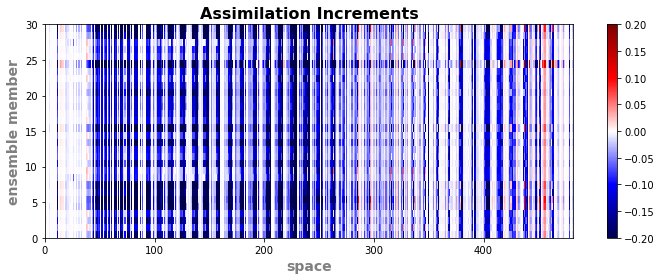

In [7]:
fig = plt.figure(figsize = (10,4))
plt.pcolor(increments.observations, vmin = -0.2, vmax =0.2, cmap = plt.cm.seismic)
plt.colorbar()
plt.xlabel('space', fontsize = 14, fontweight = 'bold', color = 'grey')
plt.ylabel('ensemble member', fontsize = 14, fontweight = 'bold', color = 'grey')
plt.title('Assimilation Increments', fontsize = 16, fontweight='bold')
plt.tight_layout()

In [8]:
# gather the adjustments of each ensemble member
li = range(5,66)
odds = [x for x in li if x % 2 == 0]

inc = []
for c in odds:
    prior = hi_model_obs.sel(copy = c).drop(['ObsTypesMetaData','QCMetaData','CopyMetaData','namelist'])
    posterior = hi_model_obs.sel(copy = c+1).drop(['ObsTypesMetaData','QCMetaData','CopyMetaData','namelist'])
    inc.append(posterior-prior)

increments = xr.concat(inc, dim = 'ens_member')

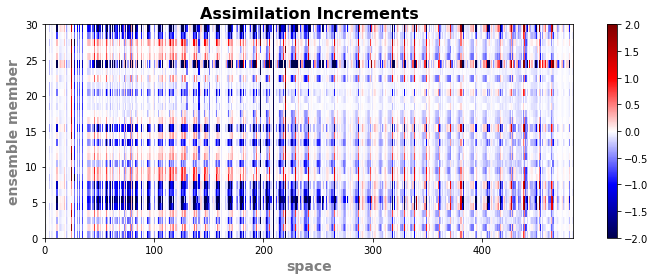

In [9]:
fig = plt.figure(figsize = (10,4))
plt.pcolor(increments.observations, vmin = -2, vmax =2, cmap = plt.cm.seismic)
plt.colorbar()
plt.xlabel('space', fontsize = 14, fontweight = 'bold', color = 'grey')
plt.ylabel('ensemble member', fontsize = 14, fontweight = 'bold', color = 'grey')
plt.title('Assimilation Increments', fontsize = 16, fontweight='bold')
plt.tight_layout()

**Summary at this point**
The increments for assimlation in the freeboard case adjust every member of the ensemble to a lower value. The increments for the thickness case have a nice mix of negative and postive adjustments, and those line up will with our understanding of where each member lies in the ensemble relative the ensemble mean. 

**Analyze the distributions of the observations relative the prior estimates** for each ensemble member, to see if the peak at lower values relative the the model's estimates is consistent across members.

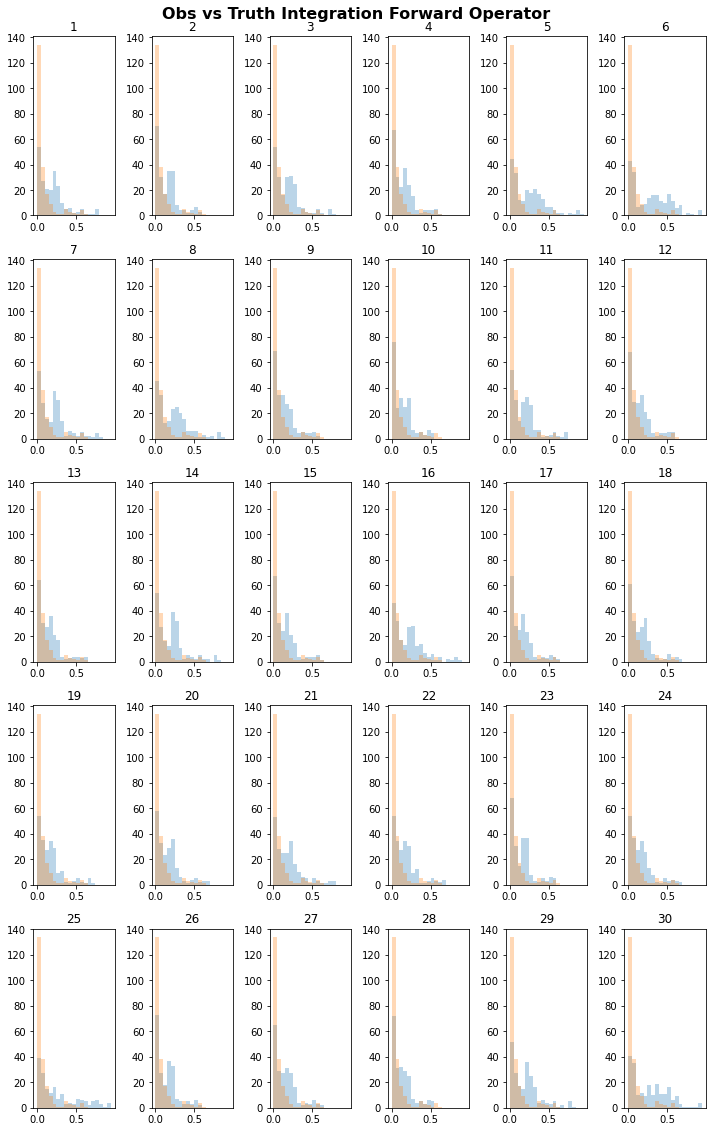

In [15]:
li = range(5,66)
odds = [x for x in li if x % 2 == 0]

inc = []

fig, axs = plt.subplots(5, 6, figsize = (10,16))

count1 = 0 
count2 = 0
count3 = 1
for c in odds:
    # do calculations
    data1 = fb_model_obs.where(fb_model_obs.qc <=3).observations.sel(copy=c)[:,1]
    data2 = fb_model_obs.where(fb_model_obs.qc <=3).observations.sel(copy=1)[:,1]
    binedges = [x/100 for x in range(0,100,5)] #,  0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
    axs[count1, count2].hist(data1, 
                             bins=binedges, 
                             alpha = 0.3,
#                              label = 'truth integration estimate'
                            ) # np.arange(np.min(data1), np.max(data1) + binwidth, binwidth), 
    axs[count1, count2].hist(data2,
                             bins=binedges, 
                             alpha = 0.3, 
#                              label = 'original obs'
                            )
    axs[count1, count2].set_title(str(count3))
    count2 += 1
    if count2 > 5:
        count2=0
        count1 += 1
        
    count3 +=1
    
plt.suptitle('Obs vs Truth Integration Forward Operator', fontweight='bold',fontsize = 16)
# plt.title('freeboard', fontweight='bold', fontsize = 14, color = 'grey')
# plt.xlabel('obs value (m)', fontweight = 'bold',fontsize = 14, color = 'grey')
# plt.ylabel('number of obs', fontweight = 'bold', fontsize = 14, color = 'grey')
# plt.legend(fontsize = 14)

plt.tight_layout()

From this we learn that our observations have more low values relative to all members of the ensemble. The increments plot thus makes sense and our likely solution is to either really validate the python forward operator relative the the DART version, or to simply use DART software to make the observations in the first place. 